In [7]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize
from create_dataset import AnimalDataset, AnimalDatasetEmbedding
from generators import OneChannelUnetGenerator, MultiChannelUnetGenerator, SkipConnectionsMultiChannelUnetGenerator, EmbeddingUnetGenerator
from discriminators import OneChannelDiscriminator, MultiChannelDiscriminator 

In [8]:
# config

ALLDATA = False # if False -> smaller dataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256  
LEARNING_RATE = 1e-4  # 1e-5 was too small for 'LVtot_kalibriert' and 'LVtot' 
NUM_WORKERS = 10
NUM_EPOCHS = 1200
LR_DECAY_AFTER_EPOCH = 800  
GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample
SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"
feature_names = [SIG_A, SIG_B, SIG_C, SIG_D]
CHANNELS = len(feature_names)
WINDOW = 256
target = TARGET

SKIPCONNECTIONS = True
EMBEDDING = True

# Abailable Generators
# GENERATOR = OneChannelUnetGenerator or MultiChannelUnetGenerator or SkipConnectionsMultiChannelUnetGenerator

# Available Discminators
# DISCRIMINTOR = OneChannelDiscriminator or MultiChannelDiscriminator


CHECKPOINT_GEN_A2B = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_B)
CHECKPOINT_GEN_B2A = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_A =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_B =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_B)
LOAD_MODEL = False
SAVE_MODEL = False


# Use cycle consistency loss
CYCLE = True
LAMBDA_CYCLE = 10.0
# Use supervised loss
SUPERVISED = True
LAMBDA_SUPERVISED = 10.0
# Use adversarial loss
ADVERSARIAL = True
LAMBDA_ADVERSARIAL = 1.0
# Use Identity loss
IDENTITY = False
LAMBDA_IDENTITY = 1.0

In [9]:
if ALLDATA == False:
    # load only a small part of the data and drop the unnecessary columns
    # paths of only a small part of the data
    path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/" 
    df = utils.load_csv(path)
    df = utils.drop_cols(df)
    df = df.dropna()

    # select only rows where 'Phasenzuordnung' is 1
    df = df.loc[df['Phasenzuordnung'] == 1]

    print(df.shape) 

(720947, 13)


In [10]:
if ALLDATA == True:
    # Load all the data and drop unnecessary columns
    # We load the data separately, to avoid a Runtime error

    # all the data
    path_1 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_1"  
    path_2 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_2"
    path_3 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_3"
    path_4 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_4"

    df_1 = utils.load_csv(path_1)
    df_1 = utils.drop_cols(df_1)

    df_2 = utils.load_csv(path_2)
    df_2 = utils.drop_cols(df_2)

    df_3 = utils.load_csv(path_3)
    df_3 = utils.drop_cols(df_3)

    df_4 = utils.load_csv(path_4)
    df_4 = utils.drop_cols(df_4)

    # concatenate the separate dataframes
    df = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)
    df = df.dropna()

    print('Size of the whole dataset',df.shape)
    # select only rows where 'Phasenzuordnung' is 1
    df = df.loc[df['Phasenzuordnung'] == 1]
    print('Size of dataset with only the first phase',df.shape)

In [11]:
df = utils.remove_strings(df)
df = utils.subsample(df, 10)
df = utils.normalize(df)

In [12]:
# hom many different intervention ids are there?
print('\nDifferent interventions: \n',df['intervention'].unique())

# hom many different animal ids are there?
print('\nDifferent animal IDs: \n',len(df['animal'].unique()))

# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('\nDifferent animal IDs after removing those with less than 10 data points: \n',len(df['animal'].unique()))

# length of data per animal
#print(df.groupby('animal').size())

all_animals = df['animal'].unique()
# pick 2 random animals for test data
test_animals = df['animal'].sample(n=1, random_state=1).unique()

# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

print('\nTest animals:', test_animals)
# test data
df_test = df[df['animal'].isin(test_animals)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: \n',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

#print('Unique animals in df_train: ',df_train['animal'].unique())
#print('Unique animals in df_test: ',df_test['animal'].unique())

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Different interventions: 
 [10  7  3  1  4  2  5  6]

Different animal IDs: 
 10

Different animal IDs after removing those with less than 10 data points: 
 6

Test animals: [19]

Different animal IDs after removing those that are in the test dataset: 
 5

Train data shape: (64342, 13)

Test data shape: (7736, 13)

The test dataset is 10.73281722578318 percent of the whole data: 


In [13]:
# class AnimalDatasetEmbedding(torch.utils.data.Dataset):
#     def __init__(self, df, feature_names, target_name, test,
#                  window_length=256):
#         self.df = df
#         self.feature_names = feature_names
#         self.target_name = target_name
#         self.window_length = window_length
#         self.test = test
        
#         self.num_animals = len(np.unique(df["animal"]))
#         self.animal_dfs = [group[1] for group in df.groupby("animal")]
#         # get statistics for test dataset
#         self.animal_lens = [len(an_df) // self.window_length for an_df in self.animal_dfs]
#         self.animal_cumsum = np.cumsum(self.animal_lens)
#         self.num_windows = sum(self.animal_lens)

        
#     def __len__(self):
#         # if self.test:
#         return self.num_windows
#         # else:
#         #     return self.num_animals
    
#     def __getitem__(self, idx):
#         if self.test:
#             # look up which test animal the idx corresponds to
#             animal_idx = int(np.where(self.animal_cumsum >= idx)[0][0])
#             animal_df = self.animal_dfs[animal_idx]
#             # look up which part of the test animal the idx corresponds to 
#             if animal_idx > 0:
#                 start_idx = idx - self.animal_cumsum[animal_idx - 1]
#             else:
#                 start_idx = idx
#             start_idx *= self.window_length
#         else:
#             # animal_df = self.animal_dfs[idx]
#             animal_idx = int(np.where(self.animal_cumsum >= idx)[0][0])
#             animal_df = self.animal_dfs[animal_idx]
            
#             # take window
#             start_idx = np.random.randint(0, len(animal_df) - self.window_length - 1)
#         end_idx = start_idx + self.window_length
#         animal_df = animal_df.iloc[start_idx: end_idx]
        
#         # extract features
#         input_df = animal_df[self.feature_names]
#         target_df = animal_df[self.target_name]
#         phase_df = animal_df["Phasenzuordnung"]
        
#         # to torch
#         inputs = torch.tensor(input_df.to_numpy()).permute(1, 0)
#         targets = torch.tensor(target_df.to_numpy()).unsqueeze(0)
#         phase = torch.tensor(phase_df.to_numpy()).type(torch.LongTensor)
        
#         return inputs, targets, phase

In [14]:
# def double_conv_pad(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
#         nn.LeakyReLU(inplace=True),
#         nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
#         nn.LeakyReLU(inplace=True)
#     )

# class EmbeddingUnetGenerator(nn.Module):
#     def __init__(self, INPUTCHANNELS, OUTPUTCHANNELS):
#         super(EmbeddingUnetGenerator, self).__init__()
#         self.maxpool = nn.MaxPool1d((2))  

#         self.down_conv1 = double_conv_pad(INPUTCHANNELS, 32) 
#         self.down_conv2 = double_conv_pad(32, 64) 
#         self.down_conv3 = double_conv_pad(64, 128)
#         self.down_conv4 = double_conv_pad(128, 256)

#         self.embedding = torch.nn.Embedding(num_embeddings=5, embedding_dim=32)

#         self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=(2), stride=2, padding=0)
#         self.up_conv1 = double_conv_pad(256, 128)
#         self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=(2), stride=2, padding=0)
#         self.up_conv2 = double_conv_pad(128, 64)
#         self.up_trans3 = nn.ConvTranspose1d(64, 32, kernel_size=(2), stride=2, padding=0)
#         self.up_conv3 = double_conv_pad(64, 32)

#         self.out = nn.Conv1d(32, OUTPUTCHANNELS, kernel_size=1) # kernel_size must be == 1

#     def forward(self, input, phase):
#         # [Batch size, Channels in, Height, Width]
        
#         # downsampling
#         x1 = self.down_conv1(input)   
#         x2 = self.maxpool(x1) 
#         x3 = self.down_conv2(x2)  
#         x4 = self.maxpool(x3) 
#         x5 = self.down_conv3(x4)  
#         x6 = self.maxpool(x5) 
#         x7 = self.down_conv4(x6)

#         # upsampling
#         e = self.embedding(phase)
#         x7 = x7 + e
#         x = self.up_trans1(x7)
#         x = self.up_conv1(torch.cat([x, x5], 1))  # skip connection
#         x = self.up_trans2(x)
#         x = self.up_conv2(torch.cat([x, x3], 1))  # skip connection
#         x = self.up_trans3(x)
#         x = self.up_conv3(torch.cat([x, x1], 1))  # skip connection
#         x = self.out(x)
#         return x

In [15]:
# initialize generator and discriminator
gen_B = EmbeddingUnetGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
gen_A = EmbeddingUnetGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)
disc_B = MultiChannelDiscriminator(CHANNELS = 1).to(DEVICE)
disc_A = MultiChannelDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

# optimizers for discriminator and generator 
opt_disc = torch.optim.AdamW(                                         
    list(disc_A.parameters()) + list(disc_B.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_A.parameters()) + list(gen_B.parameters()),
    lr=LEARNING_RATE,
)


# maybe a step learning rate would be a good idea 1e-5 -> 1e-4
# scheduler
gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = 1,
                                                    )
disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = 1,
                                                    )
# losses
l1 = nn.L1Loss() # L1 loss for cycle consistency and identity loss
mse = nn.MSELoss() # MSE loss for adversarial loss

if EMBEDDING == False:
    # create datasets  
    train_dataset = AnimalDataset(df_train, feature_names, target_name = target, test = False, window_length = WINDOW)
    test_dataset = AnimalDataset(df_test, feature_names, target_name = target, test = True, window_length = WINDOW)
    gen_dataset = AnimalDataset(df_test, feature_names, target_name = target, test = False, window_length = WINDOW)

if EMBEDDING == True:
    train_dataset = AnimalDatasetEmbedding(df_train, feature_names, target_name = target, test = False, window_length = WINDOW)
    test_dataset = AnimalDatasetEmbedding(df_test, feature_names, target_name = target, test = True, window_length = WINDOW)
    gen_dataset = AnimalDatasetEmbedding(df_test, feature_names, target_name = target, test = False, window_length = WINDOW)

# Data loader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)
gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=True, pin_memory=True,)

# run in float16
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

train_losses = {
            'Discrminator A loss' : [],
            'Discrminator B loss' : [],
            'Total Discrminator loss' : [],
            'Adversaral loss A' : [],
            'Adversaral loss B' : [],
            'Cycle consistency loss A' : [],
            'Cycle consistency loss B' : [],
            'Total Generator loss' : [],
            'Supervised loss A' : [],
            'Supervised loss B' : [],
        }

test_losses = {
            'Discrminator A loss' : [],
            'Discrminator B loss' : [],
            'Total Discrminator loss' : [],
            'Adversaral loss A' : [],
            'Adversaral loss B' : [],
            'Cycle consistency loss A' : [],
            'Cycle consistency loss B' : [],
            'Total Generator loss' : [],
            'L1 loss between real signal A and fake signals A' : [],
            'L1 loss between real signal B and fake signals B' : [],
            'Supervised loss A' : [],
            'Supervised loss B' : [],
        }

100%|██████████| 1200/1200 [12:36<00:00,  1.59it/s]

Generate fake signals
Training finished


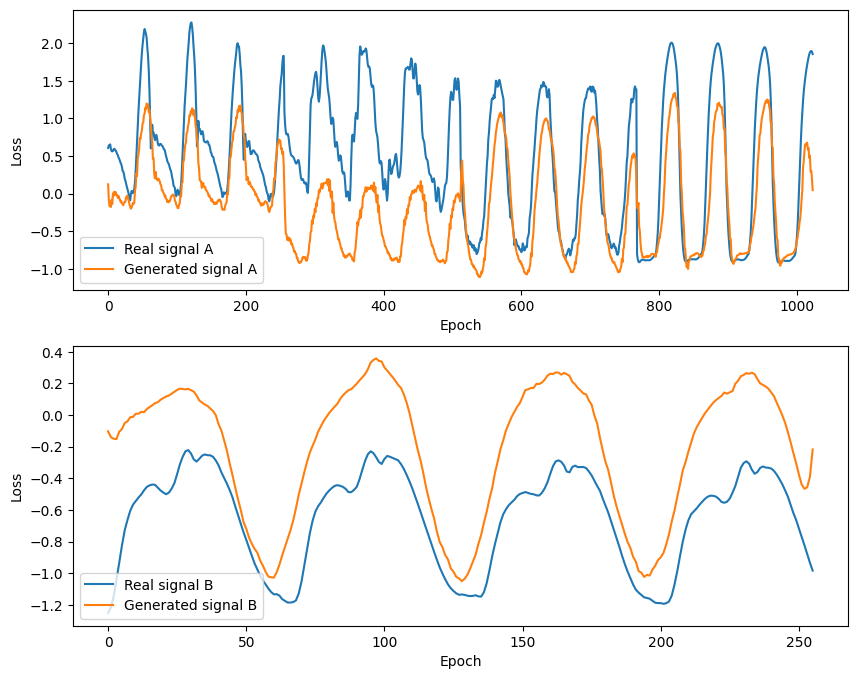

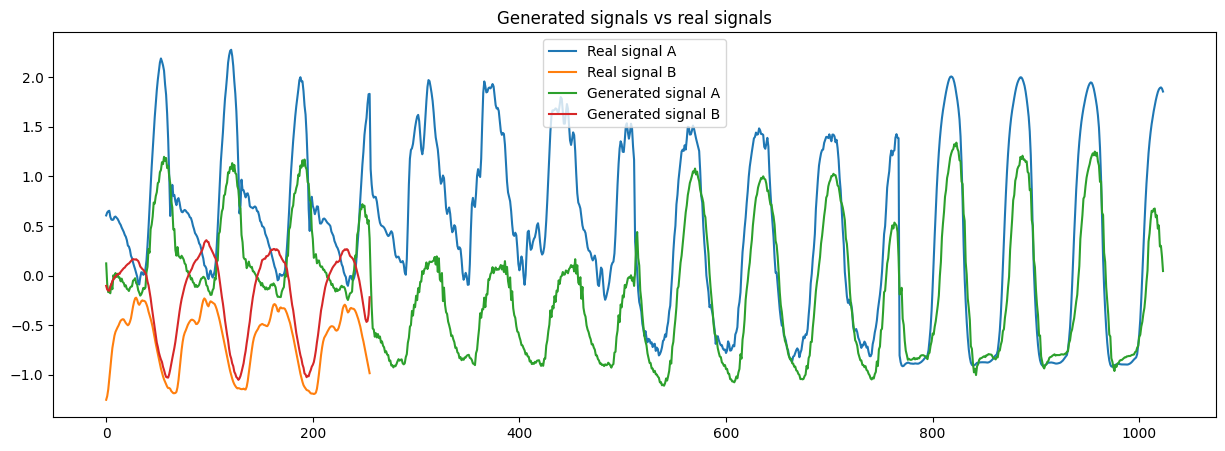

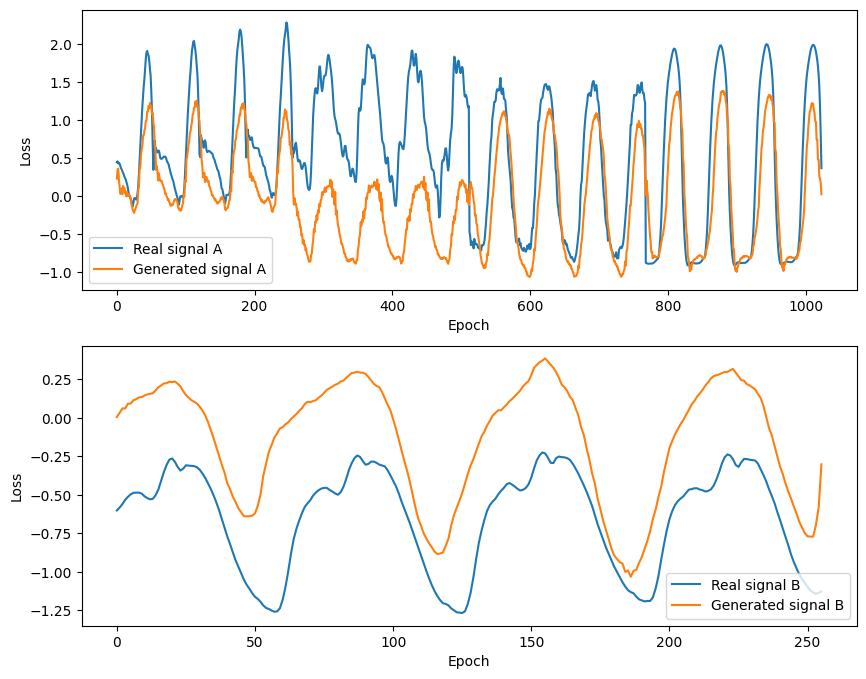

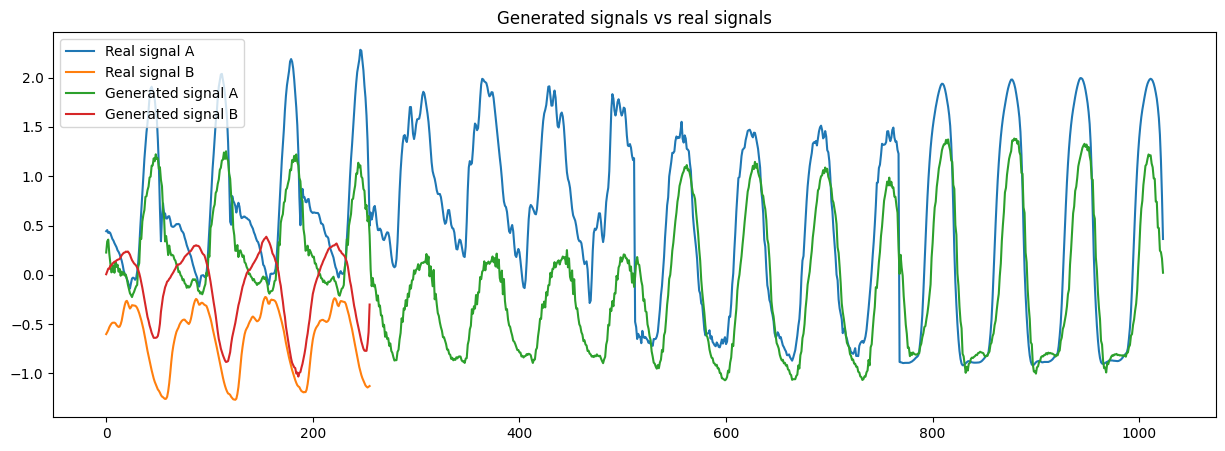

In [16]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for sig_A, sig_B, phase in loader:
        # convert to float16
        sig_A = sig_A.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        sig_B = sig_B.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        sig_A = sig_A.to(DEVICE)
        sig_B = sig_B.to(DEVICE)
        phase = phase.to(DEVICE)

        #  -------------------------------- #
        #  ----- train discriminators ----- #
        #  -------------------------------- #
        with torch.cuda.amp.autocast(): # necessary for float16

            fake_B = gen_B(sig_A, phase) # generate fake signal B
            d_B_real = disc_B(sig_B) # output of discriminator B for real signal B
            d_B_fake = disc_B(fake_B.detach()) # output of discriminator B for fake signal B (detached from generator)

            # B_reals += d_B_real.mean().item()
            # B_fakes += d_B_fake.mean().item()

            # Loss between dicriminator (with real signal) output and 1 - The discriminator should output 1 for real signals
            d_B_real_loss = mse(d_B_real, torch.ones_like(d_B_real))  
            # Loss between dicriminator (with fake signal) output and 0 - The discriminator should output 0 for fake signals
            d_B_fake_loss = mse(d_B_fake, torch.zeros_like(d_B_fake)) 
            # Total loss for discriminator B
            d_B_loss = d_B_real_loss + d_B_fake_loss

            fake_A = gen_A(sig_B, phase)
            d_A_real = disc_A(sig_A)
            d_A_fake = disc_A(fake_A.detach()) 
            d_A_real_loss = mse(d_A_real, torch.ones_like(d_A_real)) 
            d_A_fake_loss = mse(d_A_fake, torch.zeros_like(d_A_fake))  
            d_A_loss = d_A_real_loss + d_A_fake_loss

            # Total loss for discriminator A
            d_loss = d_A_loss + d_B_loss  # in cycle GAN paper they halve the loss

        # exit amp.auto_cast() context manager and backpropagate 
        opt_disc.zero_grad() 
        d_scaler.scale(d_loss).backward()  
        d_scaler.step(opt_disc)  
        d_scaler.update()
        

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 
        with torch.cuda.amp.autocast():
            
            g_loss = 0  #initialize Generator loss and add the different losses as needed

            if ADVERSARIAL:
                # ----- adversarial loss for both generators ----- #
                d_A_fake = disc_A(fake_A) # disc_A should output 0 for fake signal A
                d_B_fake = disc_B(fake_B) # disc_B should output 0 for fake signal B
                # loss between discriminator output and 0 - The discriminator should output 0 for fake signals
                g_A_loss = mse(d_A_fake, torch.ones_like(d_A_fake)) # was ones_like before  
                g_B_loss = mse(d_B_fake, torch.ones_like(d_B_fake)) # was ones_like before

                g_loss += g_A_loss * LAMBDA_ADVERSARIAL+ g_B_loss * LAMBDA_ADVERSARIAL

            if SUPERVISED:
                # supervised A loss
                sup_A_loss = mse(sig_A, fake_A)
                sup_B_loss = mse(sig_B, fake_B)

                g_loss += sup_A_loss * LAMBDA_SUPERVISED + sup_B_loss * LAMBDA_SUPERVISED
                

            if CYCLE:
                # ----- cycle consistency loss ----- #
                cycle_B = gen_B(fake_A, phase) # fake_A = gen_A(sig_B)  
                cycle_A = gen_A(fake_B, phase) # fake_B = gen_B(sig_A)
                cycle_B_loss = l1(sig_B, cycle_B)  # l1 loss: Mean absolute error between each element in the input x and target y.
                cycle_A_loss = l1(sig_A, cycle_A)

                g_loss += cycle_B_loss * LAMBDA_CYCLE + cycle_A_loss * LAMBDA_CYCLE 

            if IDENTITY:
            # ----- identity loss ----- #
                id_B = gen_B(sig_B, phase) 
                id_A = gen_A(sig_A, phase)
                id_B_loss = l1(sig_B, id_B)
                id_A_loss = l1(sig_A, id_A)

                g_loss += id_B_loss * LAMBDA_IDENTITY + id_A_loss * LAMBDA_IDENTITY

        # update gradients of generator
        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward() 
        g_scaler.step(opt_gen) 
        g_scaler.update()

    # save losses
    train_losses['Discrminator A loss'].append(d_A_loss.item())
    train_losses['Discrminator B loss'].append(d_B_loss.item())
    train_losses['Total Discrminator loss'].append(d_loss.item())
    train_losses['Adversaral loss A'].append(g_A_loss.item())
    train_losses['Adversaral loss B'].append(g_B_loss.item())
    train_losses['Cycle consistency loss A'].append(cycle_A_loss.item())
    train_losses['Cycle consistency loss B'].append(cycle_B_loss.item())
    train_losses['Total Generator loss'].append(g_loss.item())
    train_losses['Supervised loss A'].append(sup_A_loss.item())
    train_losses['Supervised loss B'].append(sup_B_loss.item())
    #train_losses['Identity loss A'].append(id_A_loss.item())
    #train_losses['Identity loss B'].append(id_B_loss.item())
    

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    #  validation every 10 epochs
    if (epoch+1) % 10 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_A.eval()  # set discriminator to evaluation mode
            disc_B.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_B.eval()
            gen_A.eval()

            # store losses for testing
            test_Discrminator_A_loss = 0 #
            test_Discrminator_B_loss = 0 #
            test_Total_Discrminator_loss = 0 #
            test_Adversaral_loss_A = 0  #
            test_Adversaral_loss_B = 0  #
            test_Cycle_consistency_loss_A = 0 #
            test_Cycle_consistency_loss_B = 0 #
            test_sup_A_loss = 0
            test_sup_B_loss = 0
            test_Total_Generator_loss = 0 #
            test_L1_real_fake_A = 0  # L1 loss between real signal A and fake signal A
            test_L1_real_fake_B = 0  # L1 loss between real signal B and fake signal B

            for sig_A, sig_B, phase in test_loader:
                # convert to float16
                sig_A = sig_A.float()
                sig_B = sig_B.float()

                # move to GPU
                sig_A = sig_A.to(DEVICE)
                sig_B = sig_B.to(DEVICE)
                phase = phase.to(DEVICE)

                fake_B = gen_B(sig_A, phase)
                fake_A = gen_A(sig_B, phase)

        
                # calculate l1 loss of fake signals and real signals
                test_L1_real_fake_B = l1(sig_B, fake_B)   # l1(sig_B, fake_B)
                test_L1_real_fake_A = l1(sig_A, fake_A)   # l1(sig_A, fake_A)

                test_Total_Generator_loss = 0 # initialize
                # calculate adversarial loss
                if ADVERSARIAL:
                    test_Adversaral_loss_B = mse(disc_B(fake_B), torch.ones_like(disc_B(fake_B))) #was ones_like before
                    test_Adversaral_loss_A = mse(disc_A(fake_A), torch.ones_like(disc_A(fake_A)))

                    test_Total_Generator_loss += test_Adversaral_loss_A * LAMBDA_ADVERSARIAL + test_Adversaral_loss_B * LAMBDA_ADVERSARIAL 

                # ----- cycle loss ----- #
                if CYCLE:
                    cycle_B = gen_B(fake_A, phase)  # fake_A = gen_B2A(sig_B)
                    cycle_A = gen_A(fake_B, phase)  # fake_B = gen_A2B(sig_A)
                    test_Cycle_consistency_loss_B = l1(sig_B, cycle_B)
                    test_Cycle_consistency_loss_A = l1(sig_A, cycle_A)

                    test_Total_Generator_loss += test_Cycle_consistency_loss_B * LAMBDA_CYCLE + test_Cycle_consistency_loss_A * LAMBDA_CYCLE

                # ----- supervise loss ------ #
                if SUPERVISED:
                    test_sup_A_loss = mse(sig_A, fake_A)
                    test_sup_B_loss = mse(sig_B, fake_B)

                    test_Total_Generator_loss += test_sup_A_loss * LAMBDA_SUPERVISED + test_sup_B_loss * LAMBDA_SUPERVISED

                # ----- identity loss ----- #
                if IDENTITY:
                    id_B = gen_B(sig_B, phase)
                    id_A = gen_A(sig_A, phase)
                    id_B_loss = l1(sig_B, id_B)
                    id_A_loss = l1(sig_A, id_A)

                    test_Total_Generator_loss += id_B_loss * LAMBDA_IDENTITY + id_A_loss * LAMBDA_IDENTITY
                    
                # ----- discriminator loss ----- #
                test_Discrminator_A_loss = mse(disc_A(sig_A), torch.ones_like(disc_A(sig_A))) + mse(disc_A(fake_A), torch.zeros_like(disc_A(fake_A)))
                test_Discrminator_B_loss = mse(disc_B(sig_B), torch.ones_like(disc_B(sig_B))) + mse(disc_B(fake_B), torch.zeros_like(disc_B(fake_B)))
                
                # ----- total discriminator loss ----- #
                test_Total_Discrminator_loss = test_Discrminator_A_loss + test_Discrminator_B_loss

                # save losses
                test_losses['Discrminator A loss'].append(test_Discrminator_A_loss.item())
                test_losses['Discrminator B loss'].append(test_Discrminator_B_loss.item())
                test_losses['Total Discrminator loss'].append(test_Total_Discrminator_loss.item())
                test_losses['Adversaral loss A'].append(test_Adversaral_loss_A.item())
                test_losses['Adversaral loss B'].append(test_Adversaral_loss_B.item())
                test_losses['Cycle consistency loss A'].append(test_Cycle_consistency_loss_A.item())
                test_losses['Cycle consistency loss B'].append(test_Cycle_consistency_loss_B.item())
                test_losses['Total Generator loss'].append(test_Total_Generator_loss.item())
                test_losses['L1 loss between real signal A and fake signals A'].append(test_L1_real_fake_A.item())
                test_losses['L1 loss between real signal B and fake signals B'].append(test_L1_real_fake_B.item())
                test_losses['Supervised loss A'].append(test_sup_A_loss.item())
                test_losses['Supervised loss B'].append(test_sup_B_loss.item())


            #  ------------------------------------- #   
            #  ------- Generate fake signals ------- #
            #  ------------------------------------- #
            
            # Generate fake signals after the last epoch
            
            if (epoch+1) % GENERATION_AFTER_EPOCH == 0:
                print('Generate fake signals')
                # generate fake signals 10 times
                #utils.save_predictions(gen_loader, gen_B, gen_A, fake_A, fake_B, DEVICE, mse)
                idx =0
                for sig_A, sig_B, phase in gen_loader:
                    if idx == 2:
                        break

                    sig_A = sig_A.float()
                    sig_B = sig_B.float()
                    sig_A = sig_A.to(DEVICE)
                    sig_B = sig_B.to(DEVICE)
                    phase = phase.to(DEVICE)

                    fake_B = gen_B(sig_A, phase)
                    fake_A = gen_A(sig_B, phase)

                    # plot generated signals and real signals
                    #reshape to 1D
                    fake_B = fake_B.reshape(-1)
                    fake_A = fake_A.reshape(-1)
                    sig_A = sig_A.reshape(-1)
                    sig_B = sig_B.reshape(-1)

                    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
                    ax[0].plot(sig_A.cpu().numpy(), label= 'Real signal A')
                    ax[0].plot(fake_A.cpu().numpy(), label= 'Generated signal A')
                    ax[0].set_xlabel('Epoch')
                    ax[0].set_ylabel('Loss')
                    ax[0].legend()

                    ax[1].plot(sig_B.cpu().numpy(), label= 'Real signal B')
                    ax[1].plot(fake_B.cpu().numpy(), label= 'Generated signal B')
                    ax[1].set_xlabel('Epoch')
                    ax[1].set_ylabel('Loss')
                    ax[1].legend()

                    # plot generated signals and real signals
                    plt.figure(figsize=(15, 5))
                    plt.plot(sig_A.cpu().detach().numpy(), label= 'Real signal A')
                    plt.plot(sig_B.cpu().detach().numpy(), label= 'Real signal B')
                    plt.plot(fake_A.cpu().detach().numpy(), label= 'Generated signal A')
                    plt.plot(fake_B.cpu().detach().numpy(), label= 'Generated signal B')
                    plt.title('Generated signals vs real signals')
                    plt.legend()

                    idx += 1
                        
                # save generated signals
                # utils.save_predictions(test_loader, gen_A, gen_B,  DEVICE)

        # activate training mode again
        disc_A.train()  
        disc_B.train()
        gen_B.train()
        gen_A.train()

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()
        
print('Training finished')

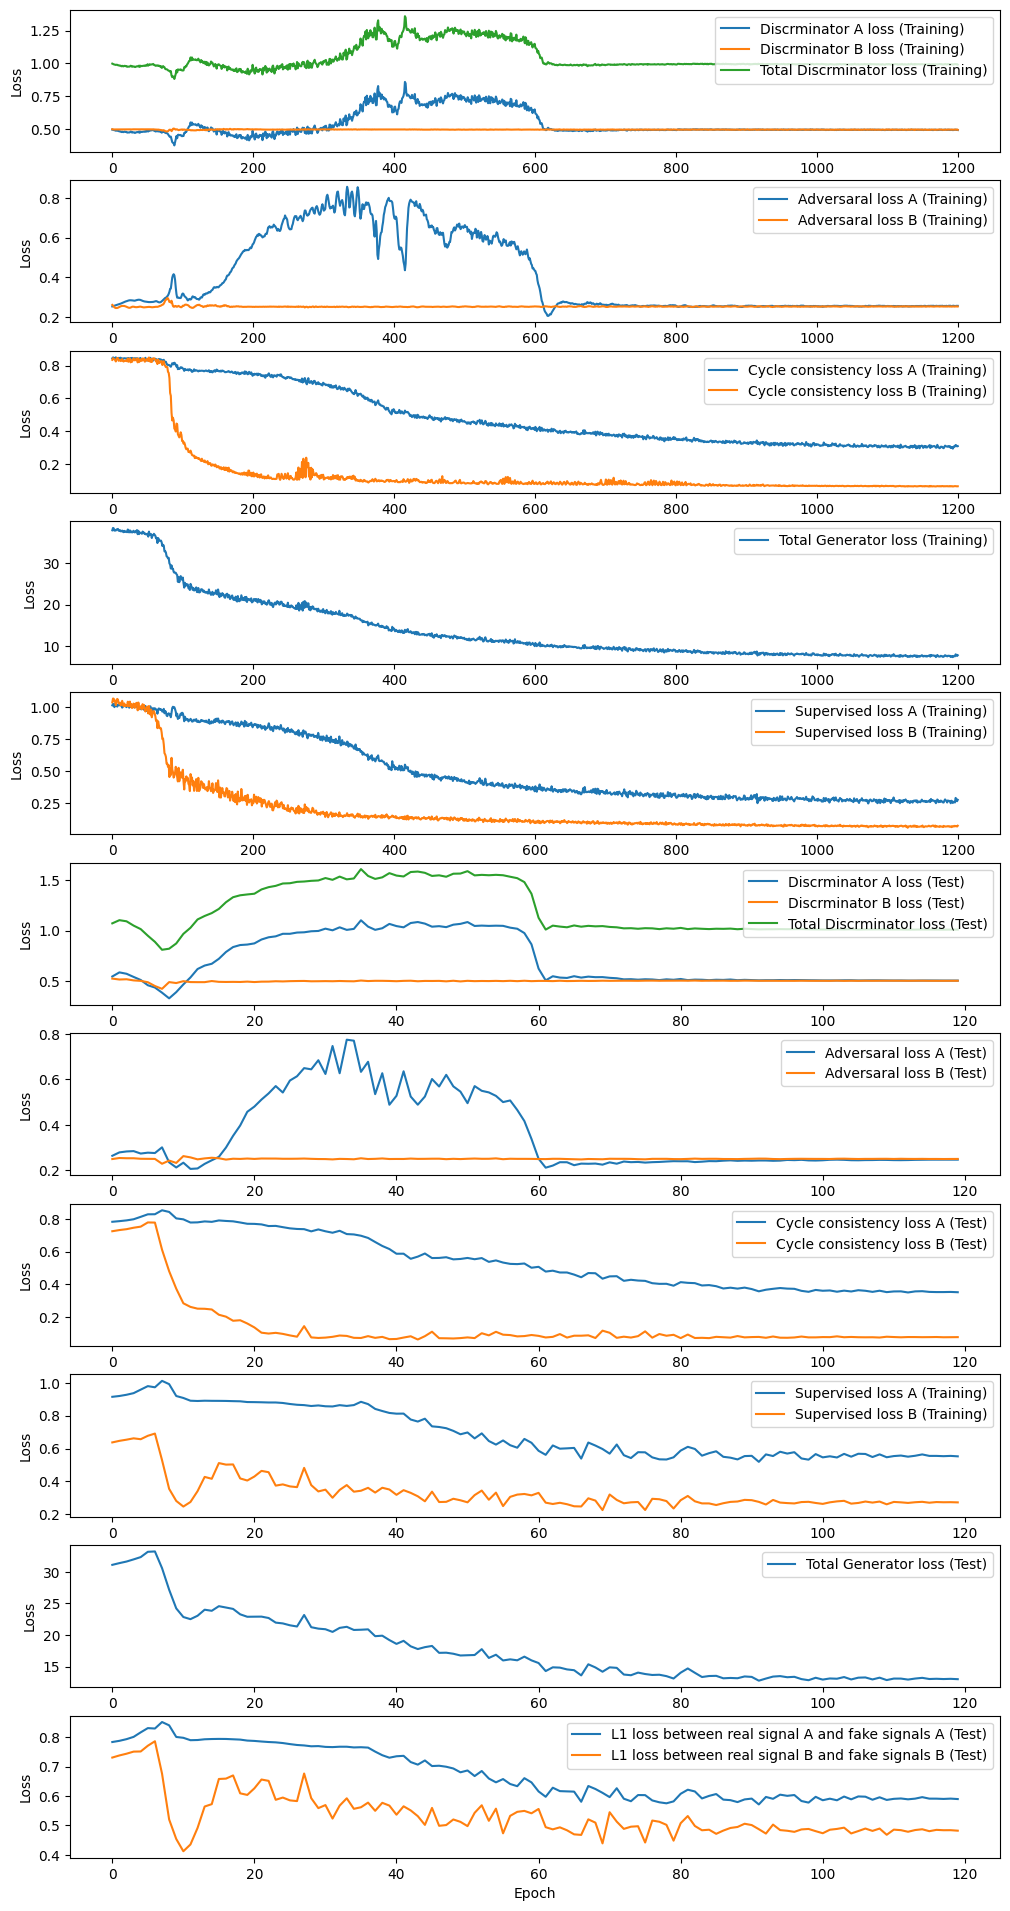

Selected losses for the test dataset after the last epoch:


L1 loss between real signal A and fake signals A:  0.5894962549209595

L1 loss between real signal B and fake signals B:  0.48188167810440063

Discrminator A loss:  0.5054787397384644

Discrminator B loss:  0.503685474395752

Total Discriminator loss:  1.0091642141342163

Adversaral loss A:  0.24603021144866943

Adversaral loss B:  0.24920015037059784

Cycle consistency loss A:  0.3514660596847534

Cycle consistency loss B:  0.07651565968990326

Supervised loss A:  0.552505373954773

Supervised loss B:  0.2724638879299164

Total Generator loss:  13.024740219116211


In [17]:
# ----------------------------------- #
# -------------- PLOT --------------- #
# ----------------------------------- #

# Plot training losses in different subplots

fig, ax = plt.subplots(11, 1, figsize=(12, 24))
ax[0].plot(train_losses['Discrminator A loss'], label= 'Discrminator A loss (Training)')
ax[0].plot(train_losses['Discrminator B loss'], label= 'Discrminator B loss (Training)')
ax[0].plot(train_losses['Total Discrminator loss'], label= 'Total Discrminator loss (Training)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
#ax[0].set_title('Training Discriminator Loss')

ax[1].plot(train_losses['Adversaral loss A'], label= 'Adversaral loss A (Training)')
ax[1].plot(train_losses['Adversaral loss B'], label= 'Adversaral loss B (Training)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
#ax[1].set_title('Training Adversarial Loss')
ax[2].plot(train_losses['Cycle consistency loss A'], label= 'Cycle consistency loss A (Training)')
ax[2].plot(train_losses['Cycle consistency loss B'], label= 'Cycle consistency loss B (Training)')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
#ax[2].set_title('Training Cycle Consistency Loss')
ax[3].plot(train_losses['Total Generator loss'], label= 'Total Generator loss (Training)')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()
#ax[3].set_title('Training Total Generator Loss')
ax[4].plot(train_losses['Supervised loss A'], label = 'Supervised loss A (Training)')
ax[4].plot(train_losses['Supervised loss B'], label = 'Supervised loss B (Training)')
ax[4].set_xlabel('Epoch')
ax[4].set_ylabel('Loss')
ax[4].legend()

# Plot test losses in different subplots

ax[5].plot(test_losses['Discrminator A loss'], label= 'Discrminator A loss (Test)')
ax[5].plot(test_losses['Discrminator B loss'], label= 'Discrminator B loss (Test)')
ax[5].plot(test_losses['Total Discrminator loss'], label= 'Total Discrminator loss (Test)')
ax[5].set_xlabel('Epoch')
ax[5].set_ylabel('Loss')
ax[5].legend()
#ax[4].set_title('Test Discriminator Loss')

ax[6].plot(test_losses['Adversaral loss A'], label= 'Adversaral loss A (Test)')
ax[6].plot(test_losses['Adversaral loss B'], label= 'Adversaral loss B (Test)')
ax[6].set_xlabel('Epoch')
ax[6].set_ylabel('Loss')
ax[6].legend()
#ax[5].set_title('Test Adversarial Loss')

ax[7].plot(test_losses['Cycle consistency loss A'], label= 'Cycle consistency loss A (Test)')
ax[7].plot(test_losses['Cycle consistency loss B'], label= 'Cycle consistency loss B (Test)')
ax[7].set_xlabel('Epoch')
ax[7].set_ylabel('Loss')
ax[7].legend()
#ax[6].set_title('Test Cycle Consistency Loss')

ax[8].plot(test_losses['Supervised loss A'], label = 'Supervised loss A (Training)')
ax[8].plot(test_losses['Supervised loss B'], label = 'Supervised loss B (Training)')
ax[8].set_xlabel('Epoch')
ax[8].set_ylabel('Loss')
ax[8].legend()

ax[9].plot(test_losses['Total Generator loss'], label= 'Total Generator loss (Test)')
ax[9].set_xlabel('Epoch')
ax[9].set_ylabel('Loss')
ax[9].legend()
#ax[7].set_title('Test Total Generator Loss')

ax[10].plot(test_losses['L1 loss between real signal A and fake signals A'], label= 'L1 loss between real signal A and fake signals A (Test)')
ax[10].plot(test_losses['L1 loss between real signal B and fake signals B'], label= 'L1 loss between real signal B and fake signals B (Test)')
ax[10].set_xlabel('Epoch')
ax[10].set_ylabel('Loss')
ax[10].legend()
#ax[8].set_title('Test L1 Loss')

plt.show()

print('Selected losses for the test dataset after the last epoch:\n')
print('\nL1 loss between real signal A and fake signals A: ', test_losses['L1 loss between real signal A and fake signals A'][-1])
print('\nL1 loss between real signal B and fake signals B: ', test_losses['L1 loss between real signal B and fake signals B'][-1])
print('\nDiscrminator A loss: ', test_losses['Discrminator A loss'][-1])
print('\nDiscrminator B loss: ', test_losses['Discrminator B loss'][-1])
print('\nTotal Discriminator loss: ', test_losses['Total Discrminator loss'][-1])
print('\nAdversaral loss A: ', test_losses['Adversaral loss A'][-1])
print('\nAdversaral loss B: ', test_losses['Adversaral loss B'][-1])
print('\nCycle consistency loss A: ', test_losses['Cycle consistency loss A'][-1])
print('\nCycle consistency loss B: ', test_losses['Cycle consistency loss B'][-1])
print('\nSupervised loss A: ', test_losses['Supervised loss A'][-1])
print('\nSupervised loss B: ', test_losses['Supervised loss B'][-1])
print('\nTotal Generator loss: ', test_losses['Total Generator loss'][-1])